In [1]:
# automatically reflect changes in imported modules
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.visualization import quantity_support
quantity_support()

import utils
import utils.logging_config
utils.logging_config.set_log_level("info")
import logging
logger = logging.getLogger("task2 (mesh)")


In [2]:
DATA_ROOT = Path('data')
# DATA_NAME = 'data0.txt'
# DATA_NAME = 'data1.txt'
# DATA_NAME = 'data0_noise.txt'
DATA_NAME = 'data1_noise.txt'
CACHE_ROOT = Path('.cache')

In [3]:
points, columns = utils.load_data(DATA_ROOT / DATA_NAME)
logger.debug(f"Fetched {points.shape[0]} points, columns: {columns}")
# points = points[1:100, ...]
# points = points[::2]
# TODO remove
softenings = points[:, -1]
assert np.all(softenings == softenings[0]), "Softening lengths are not uniform"
SOFTENING = softenings[0]
logger.info(f"Softening length: {SOFTENING}")
# reorder the columns to match the expected order (x, y, z, mass)
particles = points[:, [2, 3, 4, 1]]

11:03:10 - utils.load - Loaded 9913 rows and 9 columns from data/data1_noise.txt
11:03:10 - task2 (mesh) - Softening length: 0.037


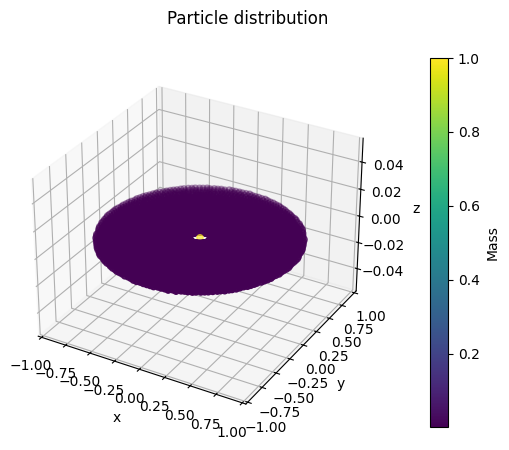

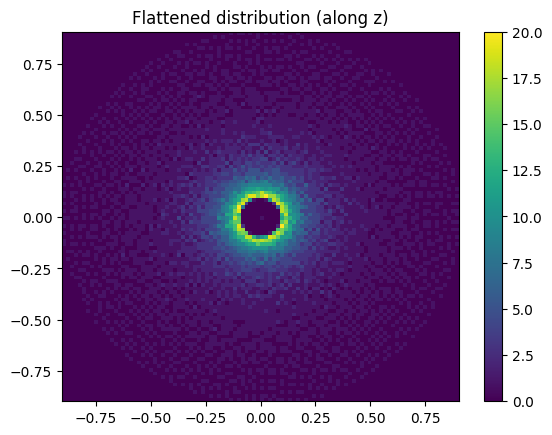

In [4]:
utils.particles_plot_3d(particles[:, :3], particles[:, 3], title="Particle distribution")
# Note: colormap corresponds to the mass of the particles
utils.particles_plot_2d(particles)
# Note: colormap corresponds to the order of the particles in the array

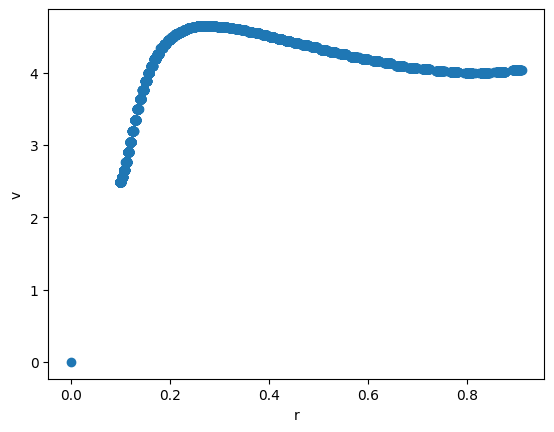

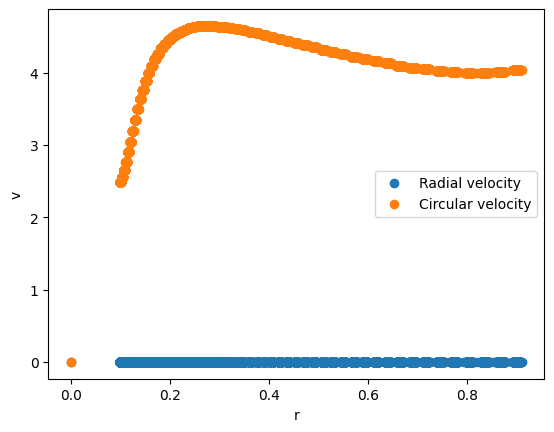

In [5]:
## Also consider the velocity distribution
velocities = points[:, [5, 6, 7]]
r = np.linalg.norm(particles[..., :3], axis=-1)
v = np.linalg.norm(velocities, axis=-1)
plt.figure()
plt.plot(r, v, 'o')
plt.xlabel('r')
plt.ylabel('v')
plt.show()

## Check the velocity direction
radial_velocities = np.zeros_like(v)
circular_velocities = np.zeros_like(v)
for i in range(particles.shape[0]):
    if r[i] > 0:
        radial_velocities[i] = np.abs(np.dot(velocities[i], particles[i, :3]) / r[i])
        circular_velocities[i] = np.linalg.norm(np.cross(particles[i, :3], velocities[i])) / r[i]
    else:
        radial_velocities[i] = 0
        circular_velocities[i] = 0

plt.figure()
plt.plot(r, radial_velocities, 'o', label="Radial velocity")
plt.plot(r, circular_velocities, 'o', label="Circular velocity")
plt.xlabel('r')
plt.ylabel('v')
plt.legend()
plt.show()

### System characteristics
- central black hole with mass $\sim 10 \%$
- particles orbit circularly in the equatorial plane


### Choice of units
Recap of the particle properties:
- $\sim 10^4$ particles
- around 1 black hole (10% of the mass)

$\implies$ ???

In [6]:
# Set G = 1
G = 1

# from the particle number we can estimate the total (stellar) mass, excluding the BH
M_TOT = 1e4 * u.M_sun
# the radius aound the black hole follows from ??? # TODO
R_TOT = 1 * u.pc

# Rescale the units of the particles - considering only the orbiting stars
M_particles = particles[:,3].sum() - 1
R_particles = np.max(np.linalg.norm(particles[:, :3], axis=1))

logger.info(f"Considering a globular cluster - total mass of stars: {M_particles}, maximum radius of particles: {R_particles}")
m_scale = M_TOT / M_particles
r_scale = R_TOT / R_particles
utils.seed_scales(r_scale, m_scale)
logger.info(f"Black hole mass: {utils.apply_units(particles[0, -1], "mass"):.2g}")


11:03:12 - task2 (mesh) - Considering a globular cluster - total mass of stars: 9.999999999999998, maximum radius of particles: 0.9096731180509756
11:03:12 - utils.units - Set scales: M_SCALE = 1e+03 solMass, R_SCALE = 1.1 pc
11:03:12 - task2 (mesh) - Black hole mass: 1e+03 solMass


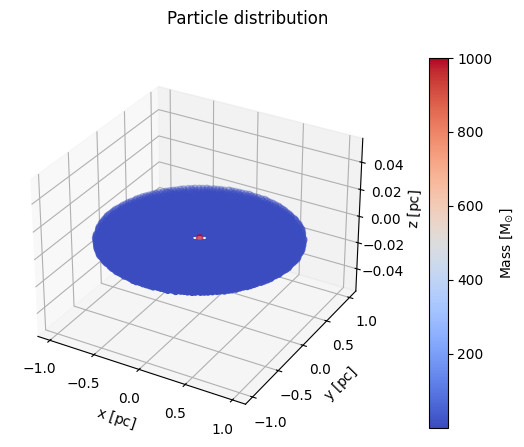

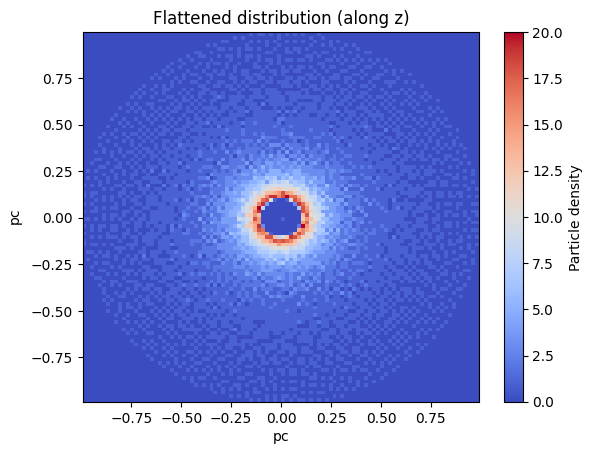

In [29]:
## Plot the particles with units applied

positions = utils.apply_units(particles[:, :3], "position")
masses = utils.apply_units(particles[:, 3], "mass")
utils.particles_plot_3d(positions, masses, title="Particle distribution")

utils.particles_plot_2d(positions)


In [8]:
### Direct N body force computation
epsilon = utils.mean_interparticle_distance(particles)

epsilon_range = np.logspace(-2, 2, 5)
epsilon_range = np.logspace(-1, 1, 3)
n_squared_forces = []

SAVE_FORCES = False

for e in epsilon_range:
    n_particles = particles.shape[0]
    cache_file = CACHE_ROOT / f"n_squared_forces__n_{n_particles}__softening_multiplier_{e:.0f}.npy"
    if cache_file.exists():
        f = np.load(cache_file)
        logger.info(f"Loaded forces from {cache_file}")
    else:
        f = utils.n_body_forces(particles, G, e * epsilon)
        if SAVE_FORCES:
            np.save(cache_file, f)
            logger.debug(f"Saved forces to {cache_file}")
    n_squared_forces.append(f)

### Mesh based force computation
mesh_size_range = [20, 75, 50, 100, 125, 150, 175, 200]
mapping = utils.particle_to_cells_nn

mesh_forces = []
for mesh_size in mesh_size_range:
    cache_file = CACHE_ROOT / f"mesh_forces__n_{n_particles}__mesh_size_{mesh_size}__mapping_{mapping.__name__}.npy"
    if cache_file.exists():
        f = np.load(cache_file)
        logger.info(f"Loaded forces from {cache_file}")
    else:
        f = utils.mesh_forces(particles, G, mesh_size, mapping)
        if SAVE_FORCES:
            np.save(cache_file, f)
            logger.debug(f"Saved forces to {cache_file}")
    mesh_forces.append(f)


# TODO: compare computation time

11:03:12 - utils.particles - Found mean interparticle distance: 0.0262396757880128
11:03:12 - task2 (mesh) - Loaded forces from .cache/n_squared_forces__n_9913__softening_multiplier_0.npy
11:03:12 - task2 (mesh) - Loaded forces from .cache/n_squared_forces__n_9913__softening_multiplier_1.npy
11:03:12 - task2 (mesh) - Loaded forces from .cache/n_squared_forces__n_9913__softening_multiplier_10.npy


11:03:12 - task2 (mesh) - Loaded forces from .cache/mesh_forces__n_9913__mesh_size_20__mapping_particle_to_cells_nn.npy
11:03:12 - task2 (mesh) - Loaded forces from .cache/mesh_forces__n_9913__mesh_size_75__mapping_particle_to_cells_nn.npy
11:03:12 - task2 (mesh) - Loaded forces from .cache/mesh_forces__n_9913__mesh_size_50__mapping_particle_to_cells_nn.npy
11:03:12 - task2 (mesh) - Loaded forces from .cache/mesh_forces__n_9913__mesh_size_100__mapping_particle_to_cells_nn.npy
11:03:12 - task2 (mesh) - Loaded forces from .cache/mesh_forces__n_9913__mesh_size_125__mapping_particle_to_cells_nn.npy
11:03:12 - task2 (mesh) - Loaded forces from .cache/mesh_forces__n_9913__mesh_size_150__mapping_particle_to_cells_nn.npy
11:03:12 - task2 (mesh) - Loaded forces from .cache/mesh_forces__n_9913__mesh_size_175__mapping_particle_to_cells_nn.npy
11:03:12 - task2 (mesh) - Loaded forces from .cache/mesh_forces__n_9913__mesh_size_200__mapping_particle_to_cells_nn.npy


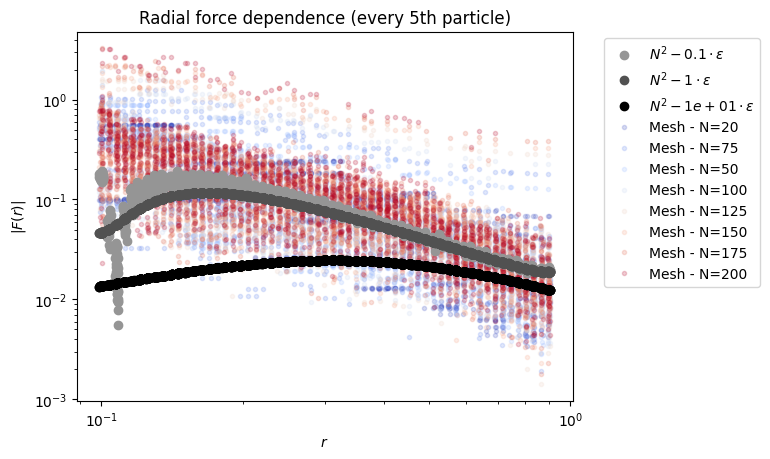

In [27]:
## Compare the mesh computation with the direct summation
r = np.linalg.norm(particles[:,:3], axis=1)

# many of the particles have the same distance from the origin, so we skip some of them
SKIP_N = 5

plt.figure()
plt.title(f'Radial force dependence (every {SKIP_N}th particle)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r$')
plt.ylabel('$|F(r)|$')


colors = plt.cm.Greys(np.linspace(0.5, 1, len(epsilon_range)))
for f, e, c in zip(n_squared_forces, epsilon_range, colors):
    # remove the black hole:
    plt.plot(r[1::SKIP_N], np.linalg.norm(f, axis=1)[1::SKIP_N], 'o', label=f"$N^2 - {e:.1g} \\cdot \\epsilon$", color=c, zorder=10)

colors = plt.cm.coolwarm(np.linspace(0, 1, len(mesh_size_range)))
for f, s, c in zip(mesh_forces, mesh_size_range, colors):
    # remove the black hole:
    plt.plot(r[1::SKIP_N], np.linalg.norm(f, axis=1)[1::SKIP_N], '.', label=f"Mesh - N={s}", alpha=0.2, color=c)

# put the legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

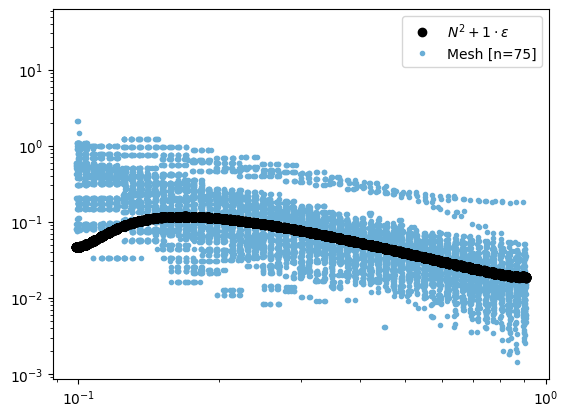

In [10]:
## Zoom in on a particularly clear case
plt.figure()
plt.xscale('log')
plt.yscale('log')

ith = 1
f = n_squared_forces[ith]
f_val = np.linalg.norm(f, axis=1)

plt.plot(r, f_val, 'o', label=f'$N^2 + {epsilon_range[ith]:.2g} \\cdot \\epsilon$', color="black", zorder=10)

f = mesh_forces[1]
f_val = np.linalg.norm(f, axis=1)

plt.plot(r, f_val, '.', label=f'Mesh [n={mesh_size_range[1]}]', color=plt.cm.Blues(0.5))
plt.legend()
plt.show()

#### Discussion
- Using the baseline of $N^2 + 1 \varepsilon$ softening we can see that already a 20 x 20 x 20 grid provides good accuracy but the mapping breaks down at small distances (dip)
- Larger grids are more stable, especially at small distances => 50 x 50 x 50 already seems to be a good choice
- very large grids show overdiscretization => noisy data even for the non-noisy particle distributions


### Time integration

In [11]:
import scipy.integrate as spi

In [12]:
# load the particles in the format [x, y, z, vx, vy, vz, mass]
p0 = points[:, [2, 3, 4, 5, 6, 7, 1]]

logger.info(f"Considering {p0.shape[0]} particles")
logger.info(f"Total mass: {np.sum(p0[:,6])}")

if logger.isEnabledFor(logging.DEBUG):
    # assert that the ODE reshaping is consistent
    p0_ref = p0.copy()
    y0, _ = utils.ode_setup(p0, None)
    logger.debug(y0[0:7])
    p0_reconstructed = utils.to_particles(y0)
    logger.debug(f"{p0_ref[0]} -> {p0_reconstructed[0]}")
    logger.debug(f"{p0_ref[1]} -> {p0_reconstructed[1]}")

    assert np.allclose(p0_ref, p0_reconstructed)
    logger.debug("Consistency check passed")


11:03:13 - task2 (mesh) - Considering 9913 particles
11:03:13 - task2 (mesh) - Total mass: 10.999999999999998


In [13]:
def integrate(method: str, force_function: callable, p0: np.ndarray, t_range: np.ndarray) -> np.ndarray:
    """
    Integrate the gravitational movement of the particles, using the specified method
    - method: the integration method to use ("scipy" or "rk4")
    - force_function: the function that computes the forces acting on the particles
    - p0: the initial conditions of the particles (n, 7) array, unflattened
    - t_range: the time range to integrate over
    Returns: the integrated positions and velocities of the particles in a 'flattened' array (time_steps, nx7)
    """
    y0, y_prime = utils.ode_setup(p0, force_function)
    
    if method == "scipy":
        sol = spi.odeint(y_prime, y0, t_range, rtol=1e-2)
    elif method == "rk4":
        sol = np.zeros((t_range.shape[0], y0.shape[0]))
        sol[0] = y0
        dt = t_range[1] - t_range[0]
        for i in range(1, t_range.shape[0]):
            t = t_range[i]
            sol[i,...] = utils.runge_kutta_4(sol[i-1], t, y_prime, dt)


    logger.info(f"Integration done, shape: {sol.shape}")
    return sol


In [14]:
# Determine the integration timesteps
# let's first compute the crossing time
v = np.linalg.norm(particles[:, 3:6], axis=1)
v_mean = np.mean(v)
# a timestep should result in a small displacement, wrt. to the mean interparticle distance
r_inter = utils.mean_interparticle_distance(particles)

dt = r_inter / v_mean * 1e-3
logger.info(f"Mean velocity: {v_mean}, timestep: {dt}")

if np.isnan(dt):
    raise ValueError("Invalid timestep")

11:03:13 - utils.particles - Found mean interparticle distance: 0.0262396757880128
11:03:13 - task2 (mesh) - Mean velocity: 0.001109653989710481, timestep: 0.023646718735142812


In [15]:
## Integration setup - use the n_squared forces for a few timesteps only, to see if the orbits are stable
t_orbit = 2 * np.pi * r_inter / v_mean
n_steps = int(t_orbit / dt * 5)
n_steps = 30
t_range = np.arange(0, n_steps*dt, dt)
assert t_range.shape[0] == n_steps
logger.info(f"Integration range: {t_range[0]} -> {t_range[-1]}, n_steps: {n_steps}")

# The force function can be interchanged
epsilon = utils.mean_interparticle_distance(particles)
if epsilon != SOFTENING:
    logger.warning(f"Given softening length {SOFTENING} does not match the mean interparticle distance {epsilon}")
    epsilon = SOFTENING

force_function = lambda x: utils.n_body_forces(x, G, epsilon)
# force_function = lambda x: 0
# force_function = lambda x: utils.n_body_forces_basic(x, G, epsilon)
# force_function = lambda x: utils.analytical_forces(x)
# force_function = lambda x: utils.mesh_forces(x, G, 135, utils.particle_to_cells_nn)

sol = integrate("rk4", force_function, p0, t_range)

11:03:13 - task2 (mesh) - Integration range: 0.0 -> 0.6857548433191415, n_steps: 30
11:03:13 - utils.particles - Found mean interparticle distance: 0.0262396757880128
11:03:13 - task2 (mesh) - Given softening length 0.037 does not match the mean interparticle distance 0.0262396757880128


NameError: name 'to_particles' is not defined

In [ ]:
### Show the evolution
particles_in_time = utils.to_particles_3d(sol)

# First show the evolution of the particles in a series of 2D heatmaps:
# reduce the font size
fig, axs = plt.subplots(4, 6, figsize=(20, 12))
fig.suptitle("Particle evolution (top view)")

print(t_range.shape)
# make sure we have enough time steps to show
diff = axs.size - particles_in_time.shape[0]
if diff > 0:
    logger.debug(f"Adding dummy time steps: {diff=} -> {axs.size=}")
    plot_t_range = np.concatenate([t_range, np.zeros(diff)])
    plot_particles_in_time = particles_in_time
elif diff < 0:
    logger.debug(f"Too many steps to plot - reducing: {particles_in_time.shape[0]} -> {axs.size}")
    # skip some of the time steps
    plot_t_range = []
    plot_particles_in_time = []
    for i in range(axs.size):
        idx = int(i / axs.size * particles_in_time.shape[0])
        # make sure we have the first and last time step are included
        if i == 0:
            idx = 0
        elif i == axs.size - 1:
            idx = particles_in_time.shape[0] - 1

        plot_t_range.append(t_range[idx])
        plot_particles_in_time.append(particles_in_time[idx])
# othwerwise, we have exactly the right number of time steps

for p, t, a in zip(plot_particles_in_time, plot_t_range, axs.flat):
    a.set_title(f"t={t:.2g}")
    utils.particles_plot_2d(p, ax=a)

plt.show()


In [ ]:
#### Plot some key quantities of the system as a whole
# sol has the shape (n_steps, n_particles*6) where the first 3*n are the positions and the last 3*n are the velocities

# kinetic energy
energies = np.zeros(n_steps)
for i in range(n_steps):
    p = particles_in_time[i]
    ke_per_particle = 0.5 * p[:, 6] * np.linalg.norm(p[:,3:6], axis=1)**2
    # logger.debug(f"KE: {ke_per_particle.shape}")
    k_e = np.sum(ke_per_particle)
    energies[i] = k_e

plt.figure()
plt.plot(t_range, energies)
plt.title('Kinetic energy')
plt.xlabel('Integration time')
plt.ylabel('Energy')
plt.show()


# radial extrema of the particles - disk surface
r_mins = np.zeros(n_steps)
r_maxs = np.zeros(n_steps)
for i in range(n_steps):
    p = particles_in_time[i][1:,...] # remove the black hole
    r = np.linalg.norm(p[:,:3], axis=1)
    r_mins[i] = np.min(r)
    r_maxs[i] = np.max(r)

plt.figure()
plt.plot(t_range, r_mins, label='r_min')
plt.plot(t_range, r_maxs, label='r_max')
plt.title('Radial extrema')
plt.xlabel('Integration time')
plt.ylabel('r')
plt.legend()
plt.show()

### Full PM solver
We now have all the tools to implement the full PM solver:
- force computation using mesh
- integrator with RK4
- estimate for good timesteps

In [16]:
t_orbit = 2 * np.pi * r_inter / v_mean
n_steps = int(t_orbit / dt * 5)
n_steps = 10
t_range = np.arange(0, n_steps*dt, dt)
logger.info(f"Integration range: {t_range[0]} -> {t_range[-1]}, n_steps: {n_steps}")


mesh_size = 125 # as per the previous discussion
r = np.linalg.norm(particles[:,:3], axis=1)
r_max = np.max(r)
mesh_bound = (-2*r_max, 2*r_max)

# The force function is now more "rigid" => the mesh is fixed and boundary conditions are enforced
force_function = lambda x: utils.mesh_solver(x, G, utils.particle_to_cells_nn, mesh_size, mesh_bound, "vanishing")
sol = integrate("rk4", force_function, p0, t_range)

22:37:37 - task2 (mesh) - Integration range: 0.0 -> 0.2128204686162853, n_steps: 10


22:38:43 - task2 (mesh) - Integration done, shape: (10, 69391)


(10,)
0
(9913, 7)
0
(9913, 7)
0
(9913, 7)
0
(9913, 7)
0
(9913, 7)
0
(9913, 7)
0
(9913, 7)
0
(9913, 7)
0
(9913, 7)
0
(9913, 7)


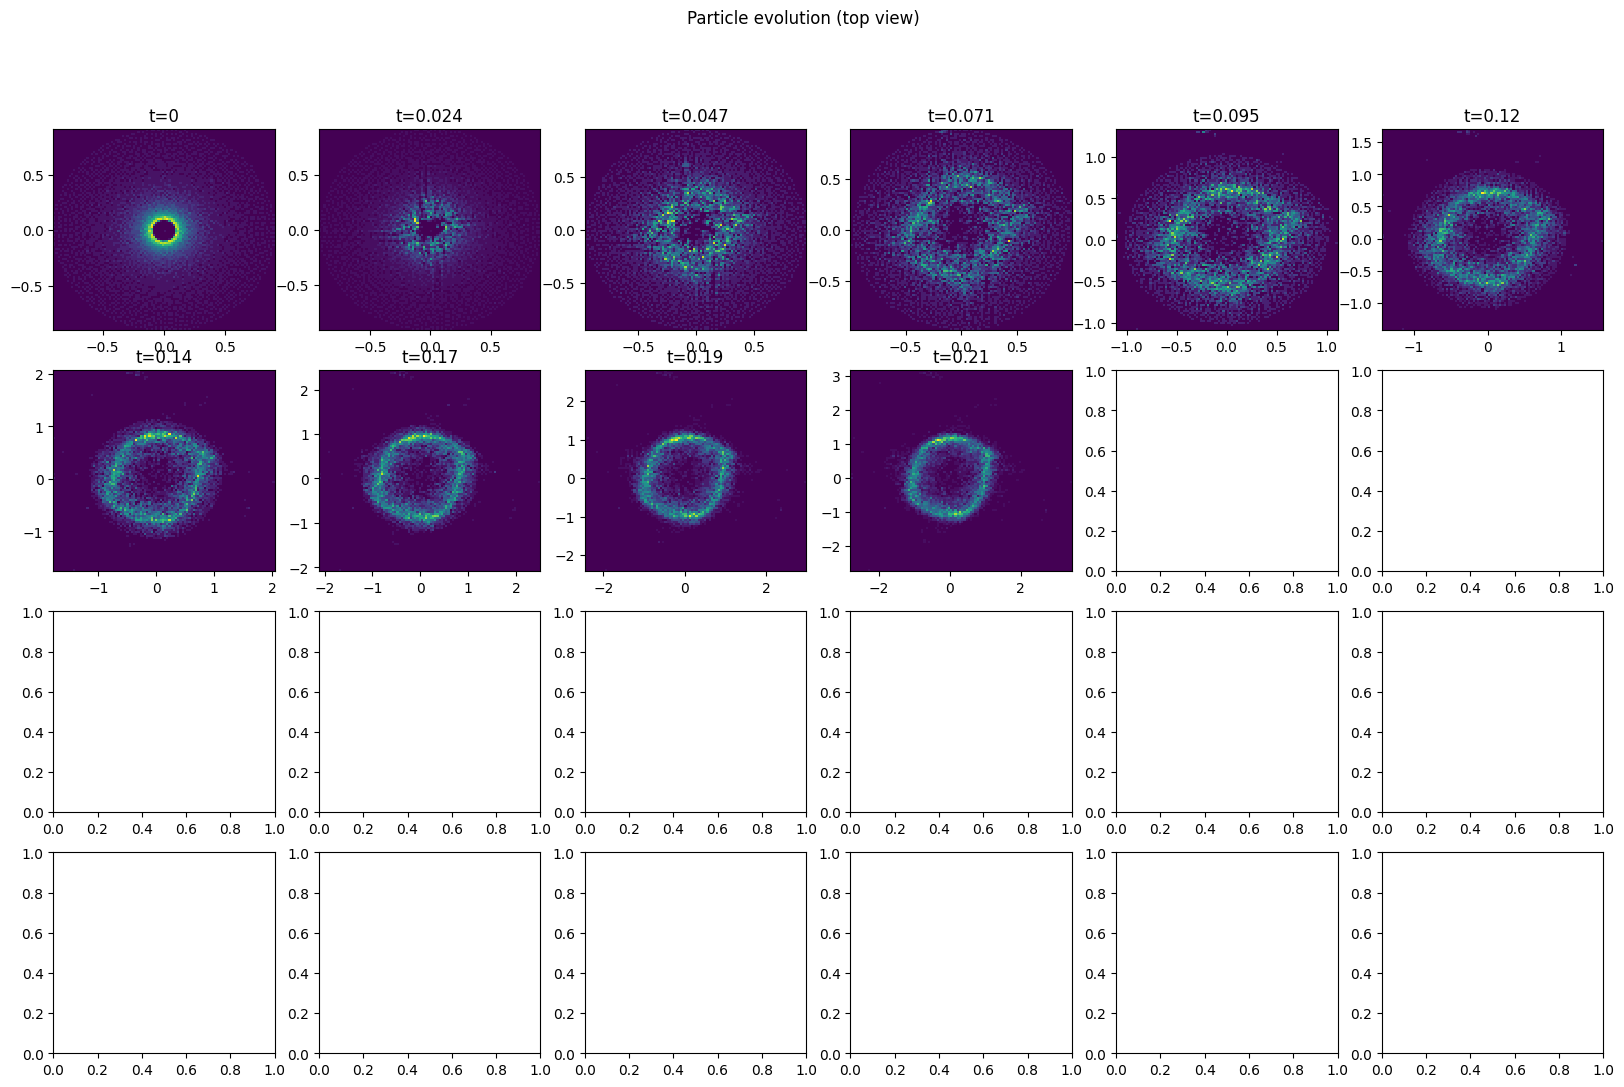

In [17]:
## Show some results
particles_in_time = utils.to_particles_3d(sol)

# First show the evolution of the particles in a series of 2D heatmaps:
# reduce the font size
fig, axs = plt.subplots(4, 6, figsize=(20, 12))
fig.suptitle("Particle evolution (top view)")

print(t_range.shape)
# make sure we have enough time steps to show
diff = axs.size - particles_in_time.shape[0]
if diff > 0:
    logger.debug(f"Adding dummy time steps: {diff=} -> {axs.size=}")
    plot_t_range = np.concatenate([t_range, np.zeros(diff)])
    plot_particles_in_time = particles_in_time
elif diff < 0:
    logger.debug(f"Too many steps to plot - reducing: {particles_in_time.shape[0]} -> {axs.size}")
    # skip some of the time steps
    plot_t_range = []
    plot_particles_in_time = []
    for i in range(axs.size):
        idx = int(i / axs.size * particles_in_time.shape[0])
        # make sure we have the first and last time step are included
        if i == 0:
            idx = 0
        elif i == axs.size - 1:
            idx = particles_in_time.shape[0] - 1

        plot_t_range.append(t_range[idx])
        plot_particles_in_time.append(particles_in_time[idx])
# othwerwise, we have exactly the right number of time steps

for p, t, a in zip(plot_particles_in_time, plot_t_range, axs.flat):
    a.set_title(f"t={t:.2g}")
    # remove nan values
    print(np.sum(np.isnan(p)))
    p = p[~np.isnan(p).any(axis=1)]
    print(p.shape)
    utils.particles_plot_2d(p, ax=a)

plt.show()


In [16]:
import inspect

In [ ]:
print(inspect.getsource(utils.runge_kutta_4))

In [ ]:
print(inspect.getsource(utils.mesh_forces))
print(inspect.getsource(utils.mesh_poisson))